In [91]:
import numpy as np #numpy supports scientific computing and linear algebra
import pandas as pd #collection of function for data processing and analysis
import re # regular expression library
from collections import Counter #It counts each occurance of element
#Importing visualization libraries
import matplotlib.pyplot as plt #based on matlab it is python library for visualization
import seaborn as sns #It works on the top of matplotlib and provide interactive visualization
%matplotlib inline
import plotly.offline as py #Open source library for composing, editing, and sharing interactive data visualization
py.init_notebook_mode(connected=True)
from matplotlib import pyplot
import plotly.graph_objs as go
import plotly.tools as tls

# Machine learning libraries
import xgboost as xgb #Implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning
import sklearn # Sklearn is collection of various tested machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
# Load libraries for analysis and visualization
import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np  # foundational package for scientific computing
import re           # Regular expression operations
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
%matplotlib inline
import plotly.offline as py     # Open source library for composing, editing, and sharing interactive data visualization 
from matplotlib import pyplot
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter

# Machine learning libraries
import xgboost as xgb  # Implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning
import seaborn as sns  # Visualization library based on matplotlib, provides interface for drawing attractive statistical graphics

import sklearn         # Collection of machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

import warnings
warnings.filterwarnings('ignore')

## Loading DataSet 

In [222]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

PassengerId=test['PassengerId'] # store our passanger id for easy access

In [223]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [224]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
253,254,0,3,"Lobb, Mr. William Arthur",male,30.0,1,0,A/5. 3336,16.1000,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.5500,NaN,S
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
278,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
727,728,1,3,"Mannion, Miss. Margareth",female,NaN,0,0,36866,7.7375,NaN,Q


#### What are the data type of features in our data set 

In [276]:
#Lets gain some information on our data set

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 18 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null int32
Age            881 non-null int32
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null int32
Cabin          201 non-null object
Embarked       881 non-null int32
Name_length    881 non-null int64
FamilySize     881 non-null int64
IsAlone        881 non-null int64
Boys           881 non-null int64
Has_Cabin      881 non-null int64
Title          881 non-null float64
dtypes: float64(1), int32(4), int64(10), object(3)
memory usage: 110.2+ KB


## Analysis Goal

The survived variable is our lable or goal and rest all are features those we need to utilize and train our model by providing our lables. The test data set is given so that we can test our trained model on them and predict our accuracy. 

## Exploratory analysis: cleaning and engineering features

We will start with a standard approach of any kernel: correct, complete, engineer the right features for analysis

### Correcting and completing features

#### Detecting and correcting outliers

Reviewing the data, there does not appear to be any aberrant or non-acceptable data inputs

There are potential outliers that we will identify and remove with the following method

-It creates first a function called detect_outliers, implementing the Tukey method

Tukey method : if Q1 and Q3 are lower and upper quartiles respectively then, one can define a outlier to be any observation
outside the range>>>  
[ (Q1 - k( Q3 - Q1 ) , (Q3 + k(Q3 - Q1)))].
for some non negative integer k.
IQR(50%) = Q3(75%) - Q1(25%)
John Tukey proposed this test where k = 1.5 indicates an "Outlier", and k = 3 indicates the data that is "far-out" 

Any data points outside 1.5 time the IQR (1.5 time IQR below Q1, or 1.5 time IQR above Q3), is considered an outlier.

In [226]:
#Outlier detection
 
def detect_outliers(df,n,features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col],25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index       
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   


In [227]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


### Observations

-The Detect_Outliers function found 10 outliers.

-PassengerID 28, 89 and 342 passenger have an high Ticket Fare

-The seven others have very high values of SibSP.

-We will drop those.

In [228]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### Finding missing values in features

the info() method will tell us which of the columns have null values. Let's Check

Missing values can be bad, because some algorithms don't know how-to handle null values and will fail. While others, like decision trees, can handle null values.

The approach to to complete missing data is to impute using mean, median, or mean + randomized standard deviation

In [229]:
train.info()
print('-'*30)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fa

So, we have few columns those contains null values, those are [ Cabin , Embarked , Age] 

In [230]:
data = [train , test ]

In [231]:
Survival = train['Survived']
Survival.describe()

count    881.000000
mean       0.385925
std        0.487090
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

### Feature Engineering - Bi-variate statistical analysis
One of the first tasks in Data Analytics is to convert the variables into numerical/ordinal values. There are multiple types of data

a) Qualitative data: discrete

 - Nominal: no natural order between categories. In this case: Name
 - Categorical: Sex

b) Numeric or quantitative data

 - Discrete: could be ordinal like Pclass or not like Survived.
 - Continuous. e.g.: age

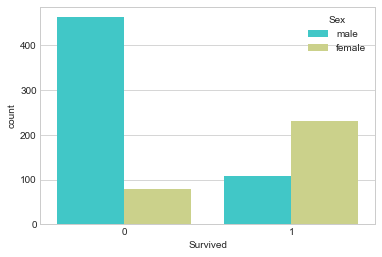

In [232]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='rainbow')

So, it is clear that the ratio of survive of Women is much more than of Men

### Pclass

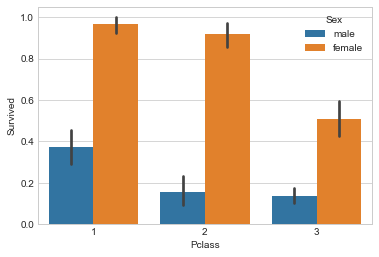

In [233]:
sns.barplot(x="Pclass", y="Survived", hue="Sex", data=train)

So, people who are in the upper class were survived the most

In [234]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Name_length

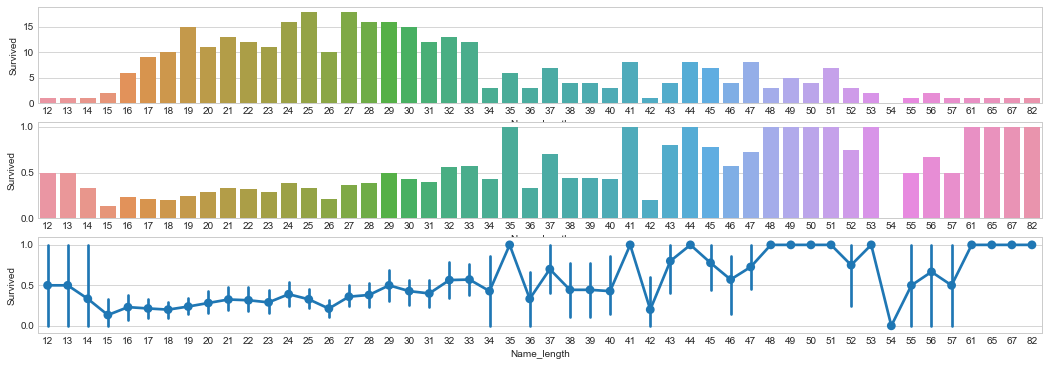

In [235]:
for dataset in data:
    dataset['Name_length'] = train['Name'].apply(len)

sum_Name = train[["Name_length", "Survived"]].groupby(['Name_length'],as_index=False).sum()
average_Name = train[["Name_length", "Survived"]].groupby(['Name_length'],as_index=False).mean()
fig, (axis1,axis2,axis3) = plt.subplots(3,1,figsize=(18,6))
sns.barplot(x='Name_length', y='Survived', data=sum_Name, ax = axis1)
sns.barplot(x='Name_length', y='Survived', data=average_Name, ax = axis2)
sns.pointplot(x = 'Name_length', y = 'Survived', data=train, ax = axis3)

The first graph shows the amount of people by Name_length.

The second one, their average survival rates.

The proposed categories are: less than 23 (mostly men), 24 to 28, 29 to 40, 41 and more (mostly women)

In [236]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,23
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,51
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,22
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,44
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,24


In [237]:
for dataset in data:
    dataset.loc[ dataset['Name_length'] <= 23, 'Name_length'] 						            = 0
    dataset.loc[(dataset['Name_length'] > 23) & (dataset['Name_length'] <= 28), 'Name_length']  = 1
    dataset.loc[(dataset['Name_length'] > 28) & (dataset['Name_length'] <= 40), 'Name_length']  = 2
    dataset.loc[ dataset['Name_length'] > 40, 'Name_length'] 							        = 3
train['Name_length'].value_counts()

0    358
1    235
2    198
3     90
Name: Name_length, dtype: int64

In [238]:
for dataset in data:# Mapping Gender
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [239]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,1


### Age

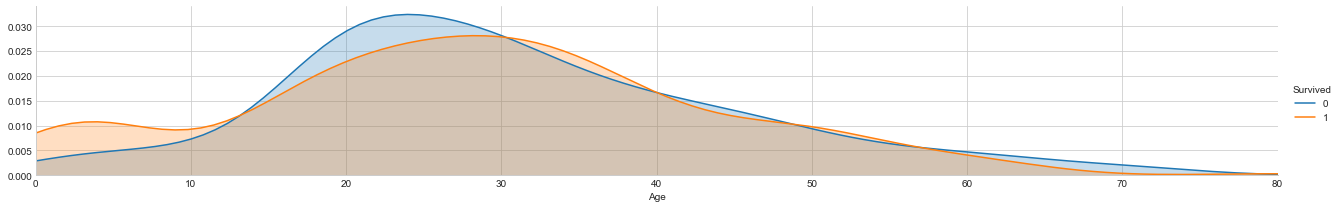

In [240]:
#plot distributions of age of passengers who survived or did not survive
plt.figure(figsize=(10,6))
a=sns.FacetGrid( train, hue = 'Survived', aspect=6 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , train['Age'].max()))
a.add_legend()

In [241]:
for dataset in data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

    dataset.loc[ dataset['Age'] <= 14, 'Age'] 						          = 0
    dataset.loc[(dataset['Age'] > 14) & (dataset['Age'] <= 30), 'Age']        = 1
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 40), 'Age']        = 2
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 50), 'Age']        = 3
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 60), 'Age']        = 4
    dataset.loc[ dataset['Age'] > 60, 'Age'] 							      = 5
train['Age'].value_counts()

1    430
2    210
3     99
0     78
4     42
5     22
Name: Age, dtype: int64

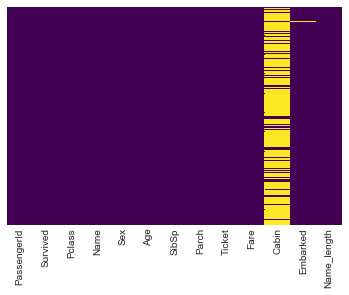

In [242]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Family: SibSp and Parch

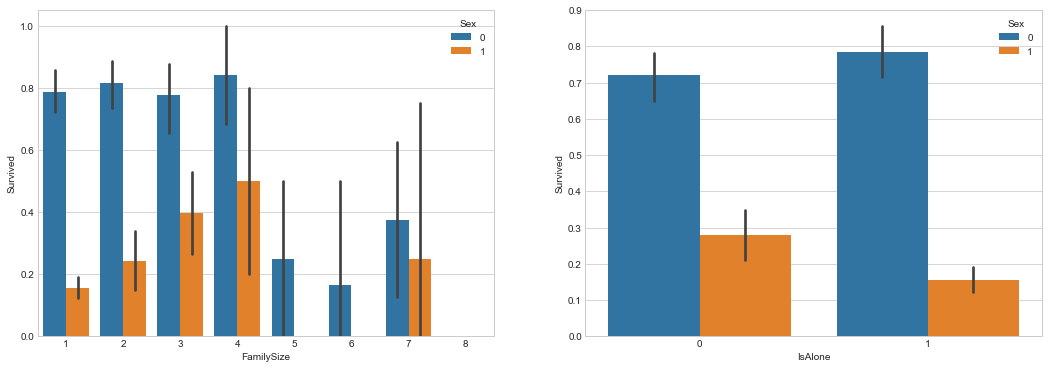

In [243]:
for dataset in data:
# Remove all NULLS in the Fare column and create a new feature Categorical Fare
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
# Create new feature FamilySize as a combination of SibSp and Parch
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Create new feature IsAlone from FamilySize
    dataset['Boys'] = 0
    dataset.loc[(dataset['Age'] == 0) & (dataset['Sex']==1), 'Boys'] = 1
    
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(18,6))
sns.barplot(x="FamilySize", y="Survived", hue="Sex", data=train, ax = axis1);
sns.barplot(x="IsAlone", y="Survived", hue="Sex", data=train, ax = axis2);

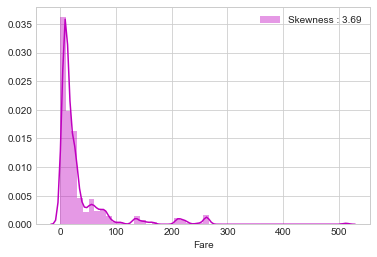

In [244]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

### Observations

 - The Fare distribution is very skewed to the left. This can lead to overweigthing the model with very high values.
 - In this case, it is better to transform it with the log function to reduce the skewness and redistribute the data.

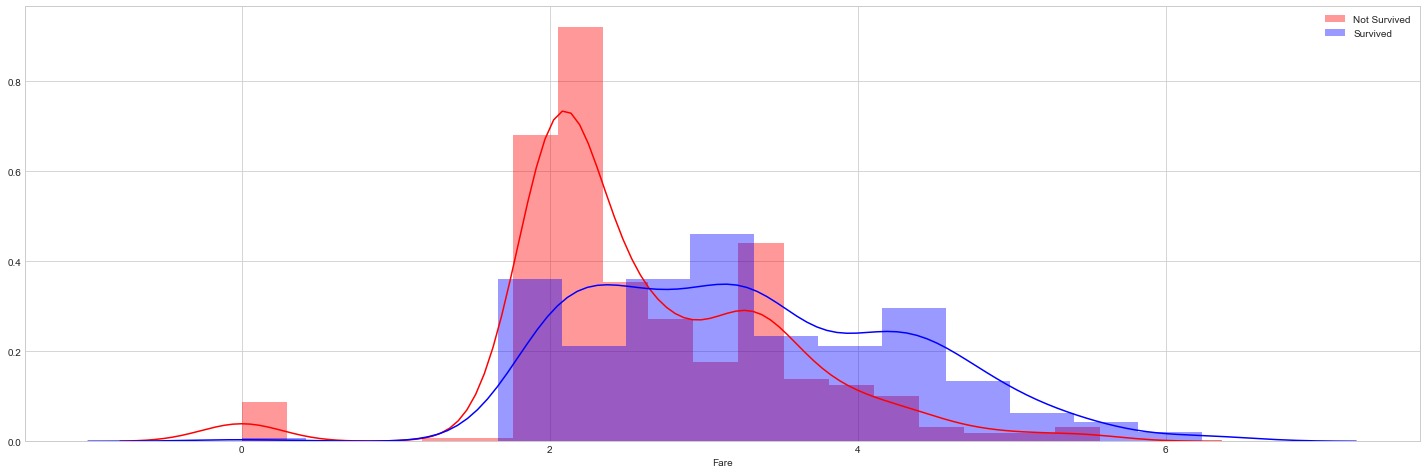

In [245]:
# Apply log to Fare to reduce skewness distribution
for dataset in data:
    dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
fig_size = (25, 8)
fig, ax = pyplot.subplots(figsize=fig_size)
g = sns.distplot(train["Fare"][train["Survived"] == 0], color="r", label="Skewness : %.2f"%(train["Fare"].skew()), ax=ax)
g = sns.distplot(train["Fare"][train["Survived"] == 1], color="b", label="Skewness : %.2f"%(train["Fare"].skew()))
g = g.legend(["Not Survived","Survived"])

#### Observations Log Fare categories are:

 - 0 to 2.7: less survivors
 - 2.7 to 3.2: more survivors
 - 3.2 to 3.6: less survivors
 - More than 3.6 more survivors

In [246]:
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 2.7, 'Fare'] 						      = 0
    dataset.loc[(dataset['Fare'] > 2.7) & (dataset['Fare'] <= 3.2), 'Fare']   = 1
    dataset.loc[(dataset['Fare'] > 3.2) & (dataset['Fare'] <= 3.6), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 3.6, 'Fare'] 							  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
train['Fare'].value_counts()

0    457
3    184
2    140
1    100
Name: Fare, dtype: int64

### Cabin

In [251]:
type(dataset['Cabin'].loc[24])

str

In [252]:
type(dataset['Cabin'].loc[0])

float

In [254]:
# Feature that tells whether a passenger had a cabin on the Titanic (O if no cabin number, 1 otherwise)
for dataset in data:
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

train[["Has_Cabin", "Survived"]].groupby(['Has_Cabin'], as_index=False).sum().sort_values(by='Survived', ascending=False)

,Has_Cabin,Survived
0,0,206
1,1,134


In [255]:
train[["Has_Cabin", "Survived"]].groupby(['Has_Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Has_Cabin,Survived
1,1,0.666667
0,0,0.302941


### Embarked

In [257]:
for dataset in data:
# Remove all NULLS in the Embarked column
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    

In [258]:
pd.pivot_table(train, values= 'Survived',index=['Embarked'],columns='Pclass',aggfunc=np.mean, margins=True)

Pclass,1,2,3,All
Embarked,,,,
0,0.587302,0.463415,0.193642,0.341195
1,0.694118,0.529412,0.378788,0.553571
2,0.500000,0.666667,0.375000,0.389610
All,0.629108,0.472826,0.245868,0.385925


In [260]:
train_pivot = pd.pivot_table(train, values= 'Survived',index=['Embarked'],columns='Pclass',aggfunc=np.mean, margins=True)
def color_negative_red(val):
    # Takes a scalar and returns a string with the css property 'color: red' if below 0.4, black otherwise.
    color = 'red' if val < 0.4 else 'black'
    return 'color: %s' % color
train_pivot = train_pivot.style.applymap(lambda x: color_negative_red(x))
train_pivot

Pclass,1,2,3,All
Embarked,,,,
0,0.587302,0.463415,0.193642,0.341195
1,0.694118,0.529412,0.378788,0.553571
2,0.5,0.666667,0.375,0.38961
All,0.629108,0.472826,0.245868,0.385925


Irrespective of the class, passengers embarked in 0 (S) and 2 (Q) have lower chance of survival. I will combine those into the first category.

In [261]:
dataset['Embarked'] = dataset['Embarked'].replace(['0', '2'], '0')
train['Fare'].value_counts()

0    457
3    184
2    140
1    100
Name: Fare, dtype: int64

### Titles

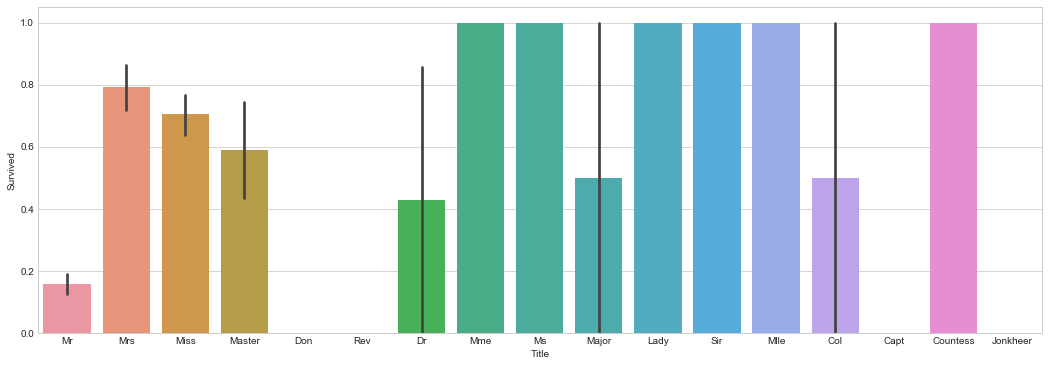

In [263]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
 # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
for dataset in data:
# Create a new feature Title, containing the titles of passenger names
    dataset['Title'] = dataset['Name'].apply(get_title)

fig, (axis1) = plt.subplots(1,figsize=(18,6))
sns.barplot(x="Title", y="Survived", data=train, ax=axis1);

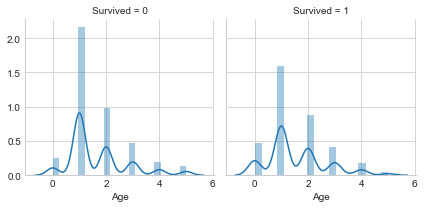

In [266]:
for dataset in data:
    dataset['Title'] = dataset['Title'].replace(['Mrs', 'Miss'], 'MM')
    dataset['Title'] = dataset['Title'].replace(['Dr', 'Major', 'Col'], 'DMC')
    dataset['Title'] = dataset['Title'].replace(['Don', 'Rev', 'Capt', 'Jonkheer'],'DRCJ')
    dataset['Title'] = dataset['Title'].replace(['Mme', 'Ms', 'Lady', 'Sir', 'Mlle', 'Countess'],'MMLSMC' )
# Mapping titles
    title_mapping = {"MM": 1, "Master":2, "Mr": 5, "DMC": 4, "DRCJ": 3, "MMLSMC": 0}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(3)
    
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

In [268]:
#train['Cabin']

### Extracting deck from cabin

A cabin number looks like ‘C123’ and the letter refers to the deck, Therefore we’re going to extract these and create a new feature, that contains a persons deck. Afterwords we will convert the feature into a numeric variable. The missing values will be converted to zero.

In [278]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int) 
train['Deck'].value_counts()

8    680
3     56
2     47
4     33
5     32
1     15
6     13
7      4
0      1
Name: Deck, dtype: int64

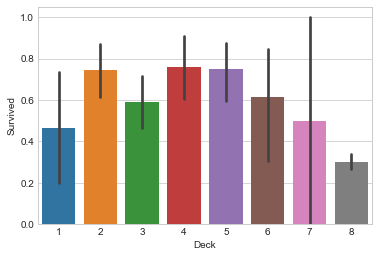

In [279]:
sns.barplot(x = 'Deck', y = 'Survived', order=[1,2,3,4,5,6,7,8], data=train)

In [281]:
for dataset in data:
    dataset.loc[ dataset['Deck'] <= 1, 'Deck'] = 1
    dataset.loc[(dataset['Deck'] > 1) & (dataset['Deck'] <= 6), 'Deck']  = 2
    dataset.loc[ dataset['Deck'] > 6, 'Deck'] = 3
train['Deck'].value_counts()

3    684
2    181
1     16
Name: Deck, dtype: int64

In [285]:
#train.head()

In [286]:
#train.describe()

In [288]:
train[['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Has_Cabin', 'FamilySize', 'Title', 'Survived']].groupby(['Survived'], as_index=False).mean().sort_values(by='Pclass', ascending=False)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,Title
0,0,2.528651,0.855823,1.659889,0.304991,0.754159,0.312384,0.123845,1.757856,3.0
1,1,1.955882,0.320588,1.550000,0.455882,1.541176,0.450000,0.394118,1.914706,3.0


Initial observations from the descriptive statistics:

- Only 38% survived, a real tragedy :-(
 - Passengers in more expensive classes 1 and 2 had much higher chance of surviving than classes 3 or 4.
 - Also, the higher the fare, the higher the chance. Similarly, having a cabin increases the chance of survival.
 - Women (0) higher chance than men (1)
 - Younger people slightly more chance than older
 - Being alone decreased your chance to survive.

### Correlational Analysis

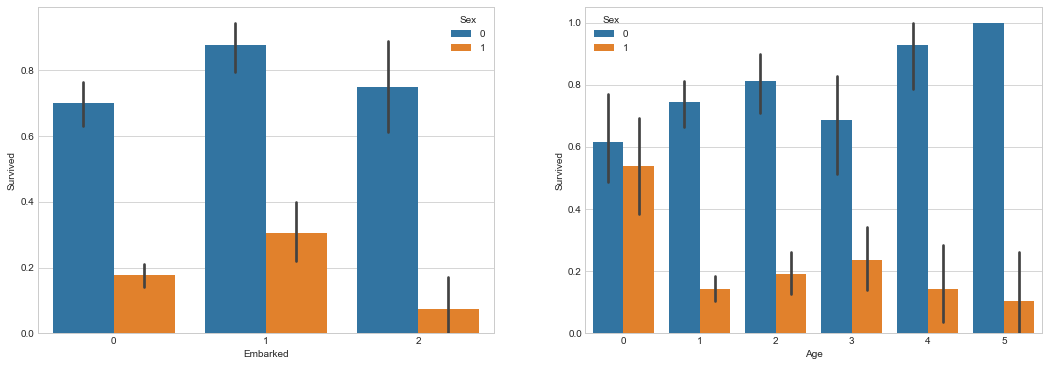

In [293]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(18,6))

sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train, ax = axis1);
#axis1.set_title('Pclass vs Fare Survival Comparison')

sns.barplot(x="Age", y="Survived", hue="Sex", data=train, ax = axis2);
#axis2.set_title('Pclass vs Fare Survival Comparison')


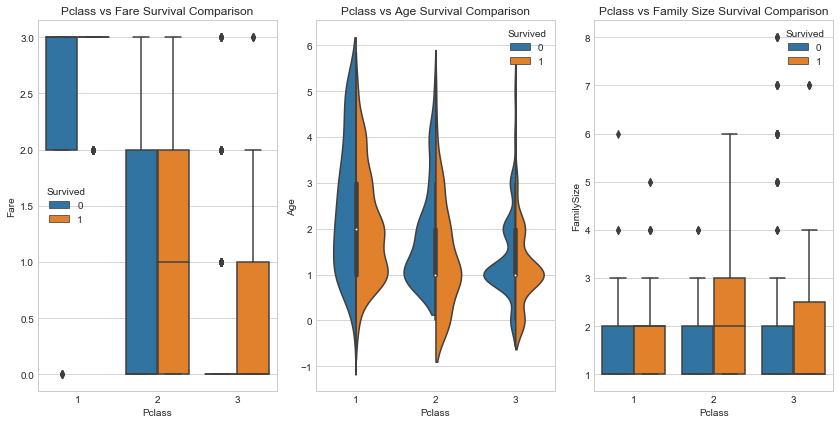

In [297]:
#graph distribution of qualitative data: Pclass
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(12,6))
sns.boxplot(x='Pclass',y='Fare',hue='Survived',data=train,ax=axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x='Pclass',y='Age',hue='Survived',data=train ,split=True,ax=axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = train, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

plt.tight_layout()

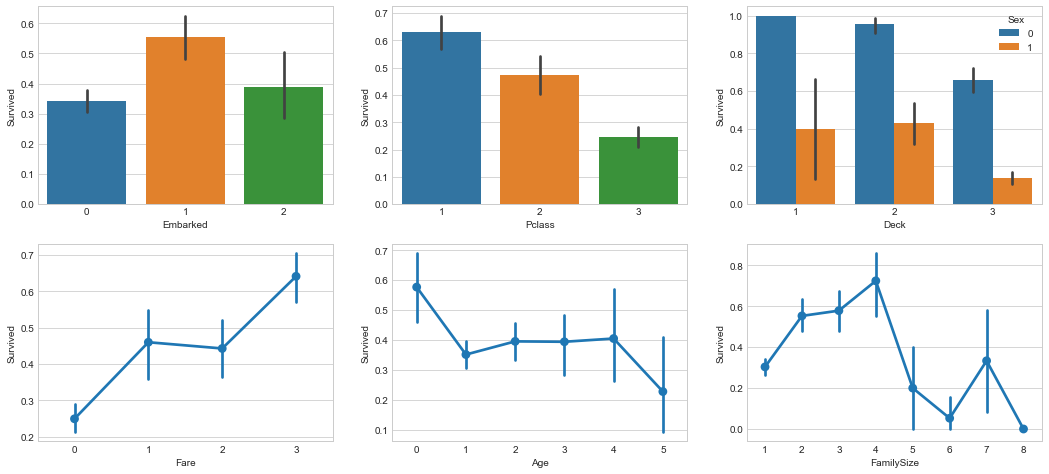

In [304]:
fig, axis = plt.subplots(2, 3,figsize=(18,8))
sns.barplot(x = 'Embarked', y = 'Survived', data=train, ax = axis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', data=train, ax = axis[0,1])
sns.barplot(x = 'Deck', y = 'Survived', data=train,hue='Sex', ax = axis[0,2])

sns.pointplot(x = 'Fare', y = 'Survived',  data=train, ax = axis[1,0])
sns.pointplot(x = 'Age', y = 'Survived',  data=train, ax = axis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=train, ax = axis[1,2])

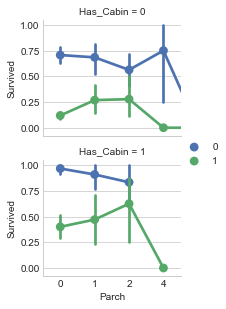

In [305]:

grid = sns.FacetGrid(train, row='Has_Cabin', size=2.2, aspect=1.2)
grid.map(sns.pointplot, 'Parch', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### Observations:

 - The colors represent: blue=0 is for women, green=1 for men
 - Clearly, women had more chance of surviving, with or without cabin

### Feature Selection

Bottom-line of the bi-variate and tri-variate analysis as well as the feature importance analysis (from running the classifiers multiple times), I decided to drop the following features:

In [306]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Boys', 'IsAlone', 'Embarked', 'Has_Cabin']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [307]:
train.head(2)

,Survived,Pclass,Sex,Age,Parch,Fare,Name_length,FamilySize,Title,Deck
0,0,3,1,1,0,0,0,2,3.0,3
1,1,1,0,2,0,3,3,2,3.0,2


In [309]:
test.head(5)

,Pclass,Sex,Age,Parch,Fare,Name_length,FamilySize,Title,Deck
0,3,1,2,0,0,0,1,3.0,3
1,3,0,3,0,0,3,2,3.0,3
2,2,1,5,0,0,0,1,3.0,3
3,3,1,1,0,0,3,1,3.0,3
4,3,0,1,1,0,1,3,3.0,3


### Correlation Heatmap

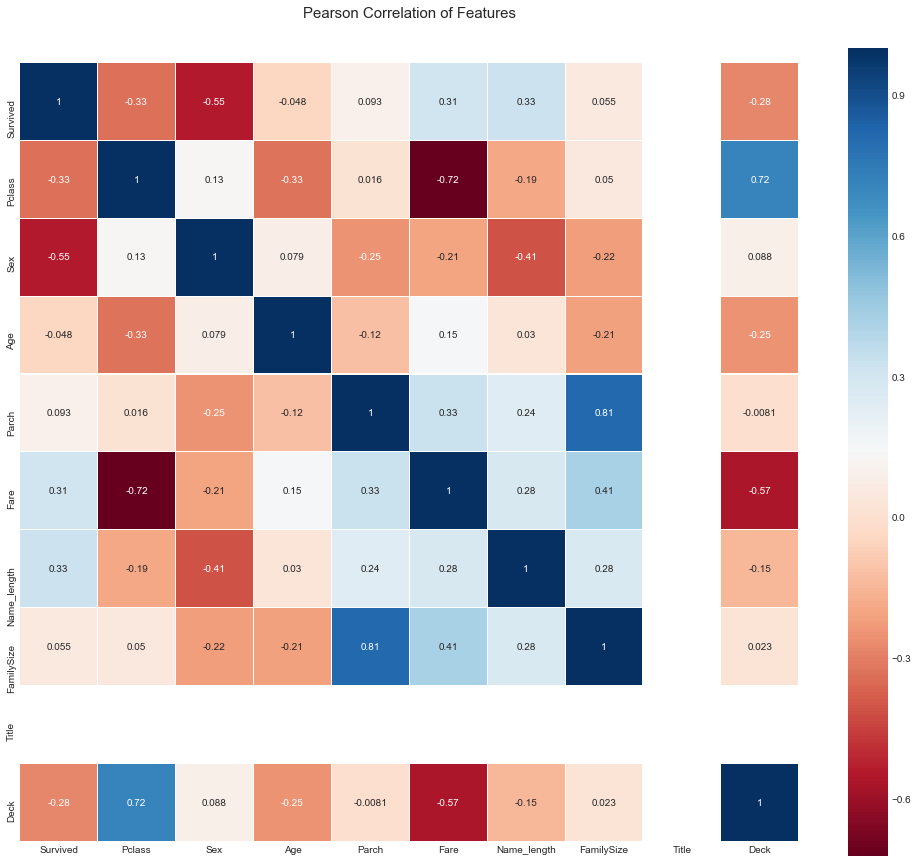

In [311]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.tight_layout()

### Pairplots

Finally let us generate some pairplots to observe the distribution of data from one feature to the other. The Seaborn pairplot class will help us visualize the distribution of a feature in relationship to each others.

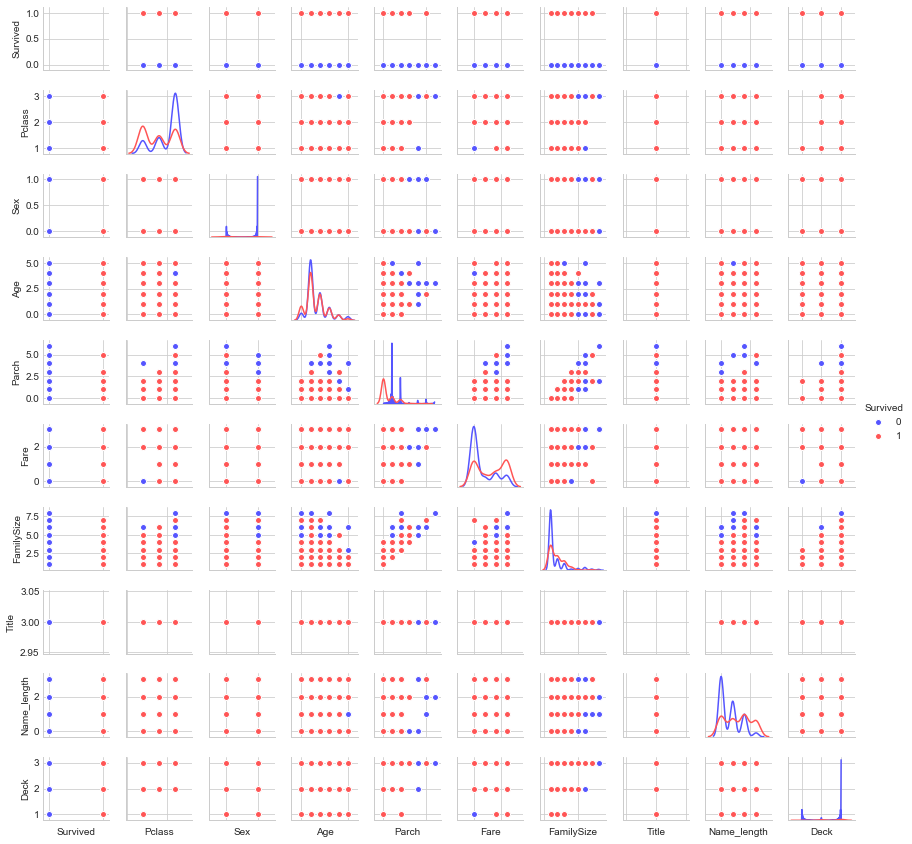

In [312]:
g = sns.pairplot(train[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare',
       'FamilySize', 'Title', 'Name_length', 'Deck']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde' )
g.set(xticklabels=[])

### Thanks Kaggler's i gained Huge Knowledge from you people.